In [15]:
import corpus as corpus_class
import categories, filters, vocabulary_builders
from feature_extractors import multinomial_model, tfidf
from filters import std_filters

import numpy as np
import warnings
warnings.simplefilter("ignore", np.VisibleDeprecationWarning)
import time

from sklearn.metrics import f1_score as f1_scorer

from sklearn.decomposition import TruncatedSVD

from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import SelectPercentile, chi2

In [16]:
corpus = corpus_class.load_from_file()

## initializing corpus

In [427]:
qfile_train = 'question_train.csv'
qcatfile_train = 'question_category_train.csv'
catfile = 'category.csv'
qfile_test = 'question_test.csv'
filtees = std_filters()

In [428]:
corpus = corpus_class.corpus( categories.categories(subcategories=False) );
corpus.load(qfile_train, qcatfile_train);
corpus.process(corpus_size=1, test_corpus=True, **filtees);
corpus.save();

In [517]:
(X_tr, y_tr), (X_te, y_te) = corpus.simple_split(0.1)
X_te.shape

(1422, 14534)

# Standart Avaraging

In [518]:
clf_nb = MultinomialNB(alpha=0.1)
clf_lr = LogisticRegression(C=2.5)

In [519]:
bcf = VotingClassifier(estimators=[('lr', clf_lr), ('nb', clf_nb)], voting='soft') #('svc', clf_svc)

In [520]:
bcf.fit(X_tr, y_tr);

In [521]:
bcf.score(X_te, y_te), f1_scorer(bcf.predict(X_te), y_te, average="macro")

(0.61111111111111116, 0.56751627216663847)

### LinearSVC

In [522]:
tfidf = TfidfTransformer()
selection = SelectPercentile(score_func=chi2, percentile=100)
lsvm = LinearSVC(C=0.48, penalty='l2')
lsvm_clf = Pipeline(steps=[('tfidf', tfidf), ('selection', selection), ('lsvm', lsvm)])
def __pri_pro(X):
    return abs(lsvm_clf.decision_function(X))
lsvm_clf.predict_proba = __pri_pro

In [523]:
lsvm_clf.fit(corpus.X_tr, corpus.y_tr);

In [524]:
lsvm_clf.score(X_te, y_te), f1_scorer(lsvm_clf.predict(X_te), y_te, average="macro")

(0.61322081575246135, 0.56435715295110034)

# Using a Classfier for avaraging

In [38]:
import importlib

In [39]:
import transform
importlib.reload( transform );

In [81]:
clf_nb = MultinomialNB(alpha=0.1)
clf_lr = LogisticRegression(C=2.94705, penalty='l1')

tfidf = TfidfTransformer()
selection = SelectPercentile(score_func=chi2, percentile=70)
lsvm = LinearSVC(C=0.48, class_weight=None, penalty='l2')
lsvm_clf = Pipeline(steps=[('tfidf', tfidf), ('selection', selection), ('lsvm', lsvm)])
def __pri_pro(X):
    return abs(lsvm_clf.decision_function(X))
lsvm_clf.predict_proba = __pri_pro

In [82]:
pbb_space = transform.ProbabilitySpace([clf_nb, clf_lr, lsvm_clf], n_folds=8)
(X_tr, y_tr), (X_te, y_te) = corpus.simple_split(0.1)

Xp_tr, yp_tr = pbb_space.fit_transform(X_tr, y_tr)
Xp_te, yp_te = pbb_space.transform(X_te, y_te)

In [83]:
bcf = VotingClassifier(estimators=[('lsvm', lsvm_clf),('lr', clf_lr), ('nb', clf_nb)], voting='hard') 
bcf.fit(X_tr, y_tr)
bcf.score(X_te, y_te), f1_scorer(bcf.predict( X_te ), y_te, average="macro")

(0.6262699564586357, 0.5723239978464153)

In [84]:
final_clf = RandomForestClassifier(n_estimators=500, max_features=6)
final_clf.fit( Xp_tr, yp_tr )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=6, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [85]:
final_clf.score( Xp_te, yp_te ), f1_scorer(final_clf.predict( Xp_te ), yp_te, average="macro")

(0.62191582002902757, 0.56165139427299893)

# Correlation

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
def corr_plot(y1, y2, corpus=corpus):
    C = np.zeros((14,14))
    for i, j in zip(y1, y2):
        C[i, j] += 1
    
    x = np.repeat(np.arange(14), 14)
    y = np.repeat(np.arange(14).reshape(1,14), 14, axis=0)
    plt.figure(figsize=(6, 4))
    
    lables = corpus.cats[:]
    plt.yticks(np.arange(14), lables, rotation=0, ha='right')

    plt.scatter(x, y, s=C.flatten())

# Evalutation

## Confidence Measures

In [ ]:
clf_fin = RandomForestClassifier(n_estimators=500, max_features=5)
clf_fin.fit(Xp_tr, yp_tr)

### for all predicitons

In [29]:
(X_tr, y_tr), (X_te, y_te) = corpus.simple_split(1/6)
FINAL.fit(X_tr, y_tr)
PP = FINAL.predict_proba(X_te)
y_pred = FINAL.predict(X_te)

PP = FINAL.predict_proba(X_te)
y_pred = FINAL.predict(X_te)
P = []
for c in range(len(corpus.cats)):
    P += [PP[y_pred == c][:,c]]

In [30]:
P = np.array(P)
sort = np.argsort( [-p.mean() for p in P] )
P = P[sort]

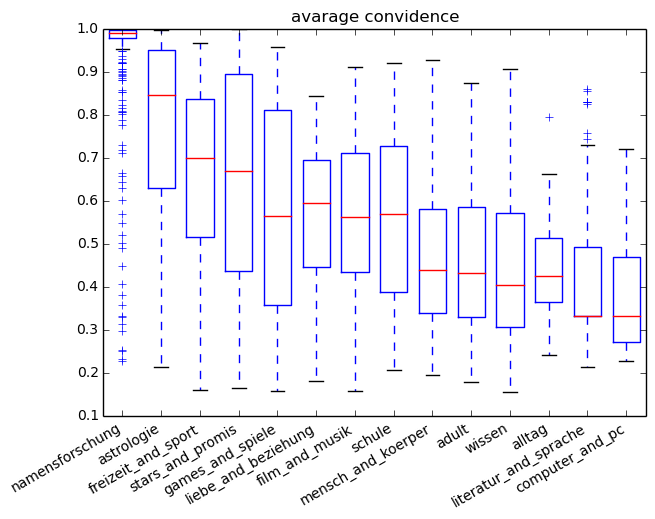

In [31]:
plt.figure(figsize=(7, 5))
plt.title('avarage convidence')
plt.boxplot(P, vert=True, widths=0.7)
lables = corpus.cats[:][sort]
plt.xticks(np.arange(14)+1, lables, rotation=30, ha='right')
plt.show()

### for wrong predicitons

In [18]:
import corpus as corpus_class
corpus = corpus_class.load_from_file()
from transform import RandForestPS
import numpy as np
from sklearn.metrics import accuracy_score

In [19]:
from os import listdir
import pickle

ESTIMATORS = []
for f in listdir("best_estimators"):
    with open("best_estimators/"+f, 'rb') as file:
        ESTIMATORS += [ ( f[:-4], pickle.load(file) ) ]
CLFS = [clf for _, clf in ESTIMATORS]

FINAL = RandForestPS(CLFS, 
                         n_folds=8, 
                         n_estimators=75, 
                         max_features=10,
                         max_depth=None,
                         min_samples_leaf=10, 
                         min_samples_split=10)

In [23]:
(X_tr, y_tr), (X_te, y_te) = corpus.simple_split(1/6)
FINAL.fit(X_tr, y_tr)
PP = FINAL.predict_proba(X_te)
y_pred = FINAL.predict(X_te)
P = []
for c in range(len(corpus.cats)):
    ps = np.array([PP[i,c] for i in range(len(y_te)) if (y_pred[i] == c)&(y_pred[i] != y_te[i])])
    P += [ps]

In [24]:
P = np.array(P)
sort = np.argsort( [-p.mean() for p in P] )
P = P[sort]

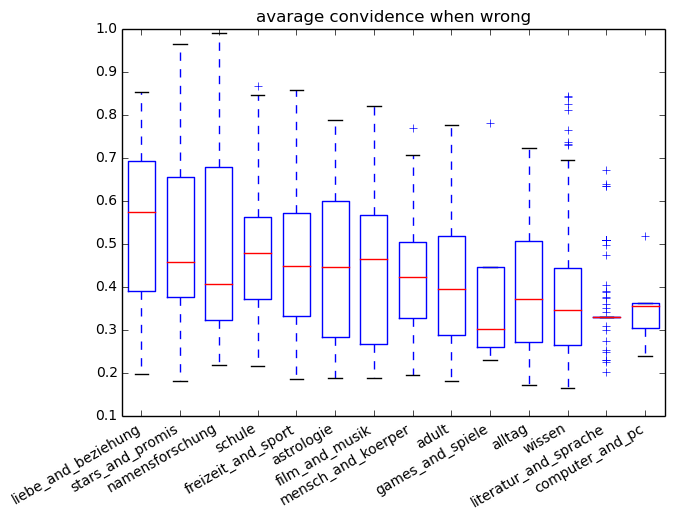

In [27]:
plt.figure(figsize=(7, 5))
plt.title('avarage convidence when wrong')
plt.boxplot(P, vert=True, widths=0.7)
lables = corpus.cats[:][sort]
plt.xticks(np.arange(14)+1, lables, rotation=30, ha='right')
plt.show() 